# Dirac Notation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

def PrettyPrintBinary(myState):
    output = f'('
    for state in myState:
        output= output + str(state[0]) + ' |' + state[1] + '> + '
    output=output[:-3]+')'
    print(output)

def PrettyPrintInteger(myState):
    output = f'('
    for state in myState:
        output= output + str(state[0]) + ' |' + str(int(state[1],2)) + '> + '
    output=output[:-3]+')'
    print(output)

In [2]:
myState2=[
  (np.sqrt(0.1)*1.j, '101'),
  (np.sqrt(0.5), '000') ,
  (-np.sqrt(0.4), '010' )
]
PrettyPrintBinary(myState2)
PrettyPrintInteger(myState2)

(0.31622776601683794j |101> + 0.7071067811865476 |000> + -0.6324555320336759 |010>)
(0.31622776601683794j |5> + 0.7071067811865476 |0> + -0.6324555320336759 |2>)


In [3]:
def DiracToVec(myState):
    vec = [0] * 2**(len(myState[0][1]))
    for state in myState:
        idx = int(state[1],2)
        vec[idx]=state[0]
    return vec

def VecToDirac(myVec):
    output = []
    bin_size = int(np.ceil(np.log2(len(myVec))))
    for i,state in enumerate(myVec):
        if state != 0:
            output.append((state,format(i,f'0{bin_size}b')))    
    return output
print(DiracToVec(myState2))
print(VecToDirac(DiracToVec(myState2)))

[0.7071067811865476, 0, -0.6324555320336759, 0, 0, 0.31622776601683794j, 0, 0]
[(0.7071067811865476, '000'), (-0.6324555320336759, '010'), (0.31622776601683794j, '101')]


# Quantum Simulators
## Simulator S

In [4]:
import itertools

def AddDuplicate(myState):
    seen=dict()
    for state in myState:
        if state[1] in seen:
            seen[state[1]]+=state[0]
        else: seen[state[1]]=state[0]
    return [(amplitude,state) for (state,amplitude) in list(seen.items()) if amplitude!=0]

myState=[
  (-np.sqrt(0.125), '11'),
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01'),
  (-np.sqrt(0.125), '11')
]

PrettyPrintBinary(AddDuplicate(myState))

myState=[
  (1j-np.sqrt(0.125), '11'),
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01'),
  (3j-np.sqrt(0.125), '11')
]
PrettyPrintBinary(AddDuplicate(myState))



(-0.7071067811865476 |11> + 0.31622776601683794 |00> + 0.6324555320336759 |01>)
((-0.7071067811865476+4j) |11> + 0.31622776601683794 |00> + 0.6324555320336759 |01>)


In [5]:
def bitFlip(idx, bitstring):
    notState = list(bitstring)
    notState[idx] = '1' if bitstring[idx]=='0' else '0'
    return ''.join(notState)  

def H(wire, inputState):
    outputState = [hadamardGate(wire, state) for state in inputState]
    return AddDuplicate(list(itertools.chain(*outputState)))
def hadamardGate(wire, state):
    notState = bitFlip(wire,state[1])
    if(state[1][wire]=='0'):
        return (1/np.sqrt(2)*state[0], state[1]),(1/np.sqrt(2)*state[0],notState)
    else:
        return (1/np.sqrt(2)*state[0], notState),(-1/np.sqrt(2)*state[0],state[1])
    
PrettyPrintBinary(H(0,[(np.sqrt(0),'0'),(np.sqrt(1),'1')]))

(0.7071067811865475 |0> + -0.7071067811865475 |1>)


In [6]:
def Phase(wire, theta, inputState):
    # Apply phase gate to each state in inputState
    return [phaseGate(wire, theta, state) for state in inputState]
def phaseGate(wire, theta, state):
    return (state[0], state[1]) if state[1][wire] == '0' else (state[0]*np.exp(1j*theta), state[1])

PrettyPrintBinary(Phase(0,np.pi/2,[(1/np.sqrt(2),'0'),(1/np.sqrt(2),'1')]))

(0.7071067811865475 |0> + (4.329780281177466e-17+0.7071067811865475j) |1>)


In [7]:
def CNOT(controlWire,notWire,inputState):
    return [cnotGate(controlWire,notWire,state) for state in inputState]
def cnotGate(controlWire,notWire,state):
    return state if state[1][controlWire]=='0' else (state[0],bitFlip(notWire,state[1]))

test = [
    (np.sqrt(.25),'00'),
    (np.sqrt(.25),'01'),
    (np.sqrt(.1),'10'),
    (np.sqrt(.4),'11')
]
PrettyPrintBinary(test)
PrettyPrintBinary(CNOT(0,1,test))

(0.5 |00> + 0.5 |01> + 0.31622776601683794 |10> + 0.6324555320336759 |11>)
(0.5 |00> + 0.5 |01> + 0.31622776601683794 |11> + 0.6324555320336759 |10>)


In [8]:
def ReadInputString(myInput_lines):
    myInput=[]
    myInput_lines=myInput_lines.split('\n')
    myInput_lines = [ i for i in myInput_lines if i!='']
    numberOfWires=int(myInput_lines[0])
    for line in myInput_lines[1:]:
        myInput.append(line.split())
    return (numberOfWires,myInput)

def RunCircuitS(numWires,circuitList):
    state = [(1,'0'*numWires)]
    for element in circuitList:
        if element[0]=='H':
            state = H(int(element[1]),state)
        elif element[0]=='P':
            state = Phase(int(element[1]),float(element[2]),state)
        elif element[0]=='CNOT':
            state = CNOT(int(element[1]),int(element[2]),state)
    return state


In [9]:
# TEST 1
numberOfWires,myInput=ReadInputString(open('example.circuit').read())
test = RunCircuitS(numberOfWires,myInput)
PrettyPrintBinary(test)
print("Passed example.circuit?: ", test==[((0.4999999999999999+0j), '0000'),
                                          ((0.4999999999999999+0j), '0011'),
                                          ((0.4502235511763384+0.21748276705561506j), '1100'),
                                          ((0.4502235511763384+0.21748276705561506j), '1111')])

(0.4999999999999999 |0000> + 0.4999999999999999 |0011> + (0.4502235511763384+0.21748276705561506j) |1100> + (0.4502235511763384+0.21748276705561506j) |1111>)
Passed example.circuit?:  True


In [10]:
# TEST 2
# Output should be 
# (0.977668244563+0.147760103331j)|000  + 
# (0.0223317554372-0.147760103331j)|101
numberOfWires,myInput=ReadInputString('''
3
H 1
H 2
P 2 0.3
CNOT 2 1
H 1
H 2
CNOT 2 0
''')

test = RunCircuitS(numberOfWires,myInput)
PrettyPrintBinary(test)

((0.9776682445628027+0.14776010333066972j) |000> + (0.022331755437197065-0.14776010333066972j) |101>)


In [11]:
# TODO: RUN rand.circuit

## Simulator M
### SImulator M-a

In [12]:
def tensorMe(matrices):
    result = matrices[0]
    for matrix in matrices[1:]:
        result = np.kron(result, matrix)
    return result

def HadamardArray(wire, numWires):
    H_matrix = 1/np.sqrt(2)*np.array([[1, 1], [1, -1]])
    return tensorMe([np.identity(2)] * wire + [H_matrix] + [np.identity(2)]*(numWires-wire-1))

def PhaseArray(wire,theta,numWires):
    P_matrix = np.array([[1,0],[0,np.exp(theta*1j)]])
    return tensorMe([np.identity(2)] * wire + [P_matrix] + [np.identity(2)]*(numWires-wire-1))

def CNOTArray(controlWire, notWire, numWires):
    C_matrix = np.array([[1, 0, 0, 0],  # bit 0 is control bit, bit 1 is not bit
                         [0, 1, 0, 0],
                         [0, 0, 0, 1],
                         [0, 0, 1, 0]])
    C_matrix_down = np.array([[1, 0, 0, 0],  # bit 0 is control bit, bit 1 is not bit
                              [0, 0, 0, 1],                              
                              [0, 0, 1, 0],
                              [0, 1, 0, 0]])
    if controlWire < notWire:
        return tensorMe([np.identity(2)] * controlWire + [C_matrix] + [np.identity(2)] * (numWires - controlWire - 2))
    else:
        return tensorMe([np.identity(2)] * notWire + [C_matrix_down] + [np.identity(2)] * (numWires - notWire - 2))

state = np.array([[x] for x in range(8)])

def RunCircuitMa(numWires, circuitList):
    circuit_matrix = np.identity(2**numWires, dtype=complex)
    for element in circuitList:
        if element[0] == 'H':
            circuit_matrix = HadamardArray(int(element[1]), numWires) @ circuit_matrix
        elif element[0] == 'P':
            circuit_matrix = PhaseArray(int(element[1]), float(element[2]), numWires) @ circuit_matrix
        elif element[0] == 'CNOT':
            circuit_matrix = CNOTArray(int(element[1]), int(element[2]), numWires) @ circuit_matrix
    state = np.array([[1] + [0] * (2**numWires - 1)], dtype=complex).T
    final_state = circuit_matrix @ state
    return VecToDirac(final_state.flatten())


In [13]:
#TEST 1
numberOfWires,myInput=ReadInputString(open('example.circuit').read())
test = RunCircuitMa(numberOfWires,myInput)
PrettyPrintBinary(test)
print("Passed example.circuit?: ", test==[((0.4999999999999999+0j), '0000'), 
                                          ((0.4999999999999999+0j), '0011'), 
                                          ((0.4502235511763384+0.21748276705561506j), '1100'), 
                                          ((0.4502235511763384+0.21748276705561506j), '1111')])

((0.4999999999999999+0j) |0000> + (0.4999999999999999+0j) |0011> + (0.4502235511763384+0.21748276705561506j) |1100> + (0.4502235511763384+0.21748276705561506j) |1111>)
Passed example.circuit?:  True


In [14]:
# TEST 2
# Output should be 
# (0.977668244563+0.147760103331j)|000>  + 
# (0.0223317554372-0.147760103331j)|101>
numberOfWires,myInput=ReadInputString('''
3
H 1
H 2
P 2 0.3
CNOT 2 1
H 1
H 2
CNOT 2 0
''')

test = RunCircuitMa(numberOfWires,myInput)
PrettyPrintBinary(test)

((0.9776682445628027+0.14776010333066972j) |000> + (0.022331755437197065-0.14776010333066972j) |001>)


In [15]:
#TODO: test rand.circuit


### Simulator M-b

In [16]:
def RunCircuitMb(numWires, circuitList):
    state = np.array([[1] + [0]*(2**numWires - 1)], dtype=complex).T
    for element in circuitList:
        if element[0]=='H':
            state = HadamardArray(int(element[1]),numWires) @ state
        elif element[0]=='P':
            state = PhaseArray(int(element[1]),float(element[2]),numWires) @ state
        elif element[0]=='CNOT':
            state = CNOTArray(int(element[1]),int(element[2]),numWires) @ state
    return VecToDirac(state.flatten())

In [17]:
#TEST 1
numberOfWires,myInput=ReadInputString(open('example.circuit').read())
test = RunCircuitMb(numberOfWires,myInput)
PrettyPrintBinary(test)
print("Passed example.circuit?: ", test==[((0.4999999999999999+0j), '0000'), 
                                          ((0.4999999999999999+0j), '0011'), 
                                          ((0.4502235511763384+0.21748276705561506j), '1100'), 
                                          ((0.4502235511763384+0.21748276705561506j), '1111')])

((0.4999999999999999+0j) |0000> + (0.4999999999999999+0j) |0011> + (0.4502235511763384+0.21748276705561506j) |1100> + (0.4502235511763384+0.21748276705561506j) |1111>)
Passed example.circuit?:  True


In [18]:

# TEST 2
# Output should be 
# (0.977668244563+0.147760103331j)|000>  + 
# (0.0223317554372-0.147760103331j)|101>
numberOfWires,myInput=ReadInputString('''
3
H 1
H 2
P 2 0.3
CNOT 2 1
H 1
H 2
CNOT 2 0
''')

test = RunCircuitMb(numberOfWires,myInput)
PrettyPrintBinary(test)


((0.9776682445628027+0.14776010333066972j) |000> + (0.022331755437197065-0.14776010333066972j) |001>)


In [19]:
#TODO: test rand.circuit


## Computational Complexity

In [20]:
def genRandCircuit(numWires,numGates=10):
    circuitList = []
    for i in range(numGates):
        gate = np.random.randint(0, 3)
        match gate:
            case 0: 
                gate = 'H'
                wire = np.random.randint(0, numWires)
                circuitList.append([gate, wire])
            case 1: 
                gate = 'P'
                wire = np.random.randint(0, numWires)
                theta = np.random.random() * 2 * np.pi
                circuitList.append([gate, wire, theta])
            case 2:
                if numWires<2: continue 
                gate = "CNOT"
                controlWire = np.random.randint(0, numWires)
                if controlWire==0 : notWire = 1
                elif controlWire == numWires-1: notWire = controlWire-1
                else:
                    notWire = controlWire + np.random.randint(-1,2)
                    while(notWire==controlWire): notWire = controlWire + np.random.randint(-1,2)
                circuitList.append([gate, controlWire, notWire])
    return circuitList

In [21]:
circuits = [genRandCircuit(x) for x in range(1, 61)]
S_times = np.zeros(60)
for numWires in range(1, 61):
    S_times[numWires - 1] = timeit.timeit(lambda numWires=numWires: RunCircuitS(numWires, circuits[numWires - 1]), number=1)
    print("Simulator S qubits completed: ", numWires)

Simulator S qubits completed:  1
Simulator S qubits completed:  2
Simulator S qubits completed:  3
Simulator S qubits completed:  4
Simulator S qubits completed:  5
Simulator S qubits completed:  6
Simulator S qubits completed:  7
Simulator S qubits completed:  8
Simulator S qubits completed:  9
Simulator S qubits completed:  10
Simulator S qubits completed:  11
Simulator S qubits completed:  12
Simulator S qubits completed:  13
Simulator S qubits completed:  14
Simulator S qubits completed:  15
Simulator S qubits completed:  16
Simulator S qubits completed:  17
Simulator S qubits completed:  18
Simulator S qubits completed:  19
Simulator S qubits completed:  20
Simulator S qubits completed:  21
Simulator S qubits completed:  22
Simulator S qubits completed:  23
Simulator S qubits completed:  24
Simulator S qubits completed:  25
Simulator S qubits completed:  26
Simulator S qubits completed:  27
Simulator S qubits completed:  28
Simulator S qubits completed:  29
Simulator S qubits comp

In [22]:
Ma_times = np.zeros(12)
for numWires in range(1,13):
    Ma_times[numWires-1] = timeit.timeit(lambda: RunCircuitMa(numWires, circuits[numWires-1]), number=1)
    print("Simulator M-a qubits completed: ",numWires)

Simulator M-a qubits completed:  1
Simulator M-a qubits completed:  2
Simulator M-a qubits completed:  3
Simulator M-a qubits completed:  4
Simulator M-a qubits completed:  5
Simulator M-a qubits completed:  6
Simulator M-a qubits completed:  7
Simulator M-a qubits completed:  8


Simulator M-a qubits completed:  9
Simulator M-a qubits completed:  10
Simulator M-a qubits completed:  11
Simulator M-a qubits completed:  12


In [23]:
Mb_times = np.zeros(13)
for numWires in range(1,14):
    Mb_times[numWires-1] = timeit.timeit(lambda: RunCircuitMb(numWires, circuits[numWires-1]), number=1)
    print("Simulator M-b qubits completed: ",numWires)

Simulator M-b qubits completed:  1
Simulator M-b qubits completed:  2
Simulator M-b qubits completed:  3
Simulator M-b qubits completed:  4
Simulator M-b qubits completed:  5
Simulator M-b qubits completed:  6
Simulator M-b qubits completed:  7
Simulator M-b qubits completed:  8
Simulator M-b qubits completed:  9
Simulator M-b qubits completed:  10
Simulator M-b qubits completed:  11
Simulator M-b qubits completed:  12
Simulator M-b qubits completed:  13


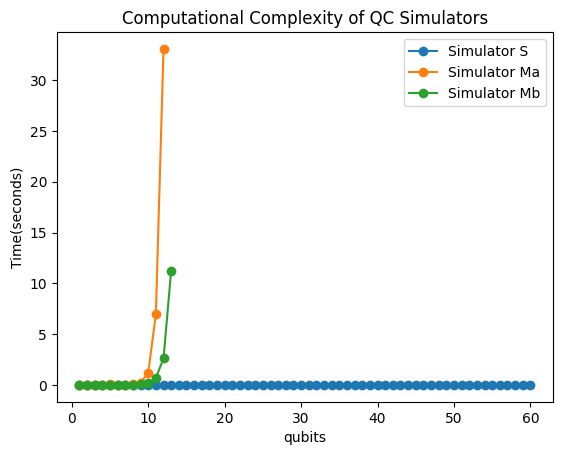

In [24]:
plt.plot(range(1,61),S_times,label="Simulator S",marker='o')
plt.plot(range(1,13),Ma_times,label="Simulator Ma",marker='o')
plt.plot(range(1,14),Mb_times[:13],label="Simulator Mb",marker='o')
plt.xlabel("qubits")
plt.ylabel("Time(seconds)")
plt.title("Computational Complexity of QC Simulators")
plt.legend()
plt.savefig('Computational Complexity Plot')
plt.show()

## Measuring and Input
### Measuring

In [25]:
def FileToState(filename):
    myInput_lines = open(filename).read()
    myInput=[]
    myInput_lines=myInput_lines.split('\n')
    myInput_lines = [ i for i in myInput_lines if i!='']
    for line in myInput_lines:
        myInput.append(line.split())
    myInput = [float(real) + float(imag)*1j for real,imag in myInput]
    return VecToDirac(myInput)
PrettyPrintInteger(FileToState("filetostatetest.txt"))    

(-0.7071j |3> + (0.7071+0j) |6>)


In [26]:
def Measure(state):
    num = np.random.random()
    idx = -1
    while(num>=0):
        idx+=1
        num = num - abs(state[idx][0])**2
    return(state[idx][1])

def ParseCircuit(InputString: str):
    if ".circuit" in InputString:
        numWires,circuitList = ReadInputString(open(InputString).read())
    else: 
        numWires,circuitList = ReadInputString(InputString)
    initState = [(1.,'0'*numWires)]
    if circuitList[0][0]=="INITSTATE":
        if circuitList[0][1]=="FILE":
            initState = FileToState(circuitList[0][2])
        elif circuitList[0][1]=="BASIS":
            initState = [(1.,circuitList[0][2][1:-1])]
        circuitList = circuitList[1:]
    return numWires, initState, circuitList

In [27]:
def SimulatorS(InputString):
    numWires,state,circuitList = ParseCircuit(InputString)
    for element in circuitList:
        if element[0]=='H':
            state = H(int(element[1]),state)    
        elif element[0]=='P':
            state = Phase(int(element[1]),float(element[2]),state)
        elif element[0]=='CNOT':
            state = CNOT(int(element[1]),int(element[2]),state)
        elif element[0]=='MEASURE':
            return Measure(state)
    return state

In [28]:
dist = []
for i in range(10000):
    result = SimulatorS("measure.circuit")
    dist.append(int(result, 2))

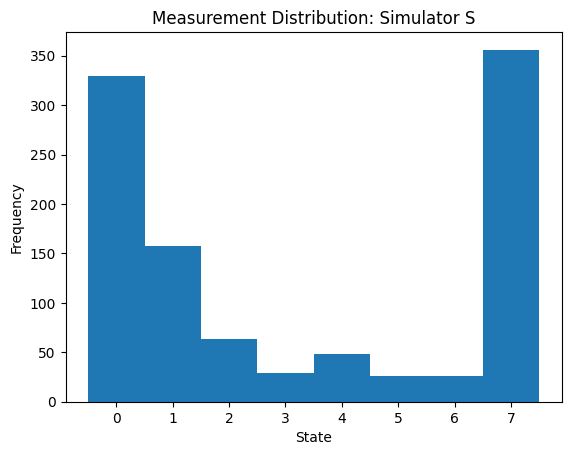

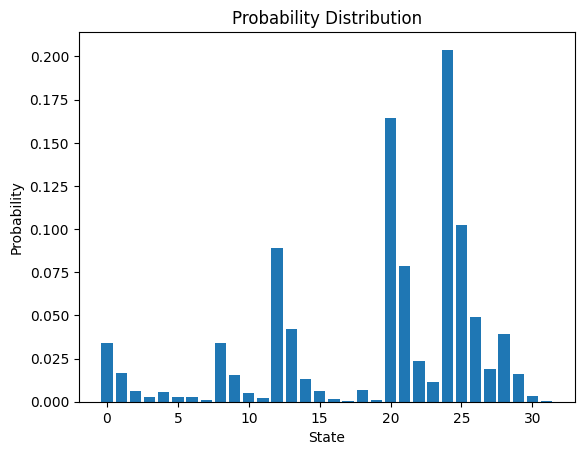

In [29]:
plt.hist(dist, bins=range(2**numberOfWires + 1), align='left')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.title('Measurement Distribution: Simulator S')
plt.show()

numberOfWires,initstate,circuitList = ParseCircuit("measure.circuit")
probabilities = [abs(x)**2 for x in DiracToVec(RunCircuitS(numberOfWires,circuitList))]
plt.bar(range(len(probabilities)),probabilities)
plt.title("Probability Distribution")
plt.xlabel('State')
plt.ylabel('Probability')
plt.show()

In [30]:
def SimulatorMa(InputString):
    numWires,state,circuitList = ParseCircuit(InputString)
    circuit_matrix = np.identity(2**numWires, dtype=complex)
    for element in circuitList:
        if element[0] == 'H':
            circuit_matrix = HadamardArray(int(element[1]), numWires) @ circuit_matrix
        elif element[0] == 'P':
            circuit_matrix = PhaseArray(int(element[1]), float(element[2]), numWires) @ circuit_matrix
        elif element[0] == 'CNOT':
            circuit_matrix = CNOTArray(int(element[1]), int(element[2]), numWires) @ circuit_matrix
    state = np.array(DiracToVec(state)).T
    final_state = circuit_matrix @ state
    if circuitList[-1][0]=='MEASURE': 
        return Measure(VecToDirac(final_state.flatten()))
    return VecToDirac(final_state.flatten())

In [31]:
dist = []
for i in range(1000):
    result = SimulatorMa("measure.circuit")
    dist.append(int(result, 2))

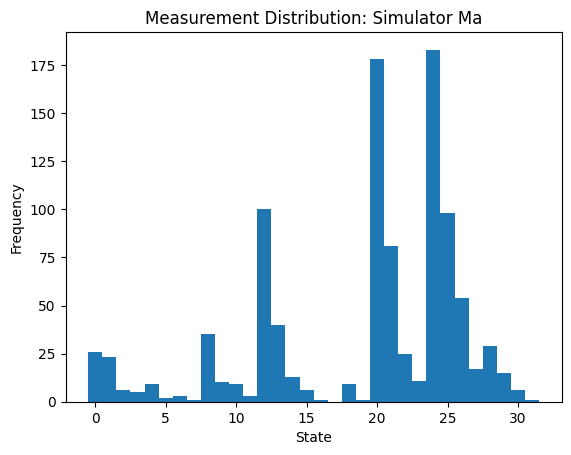

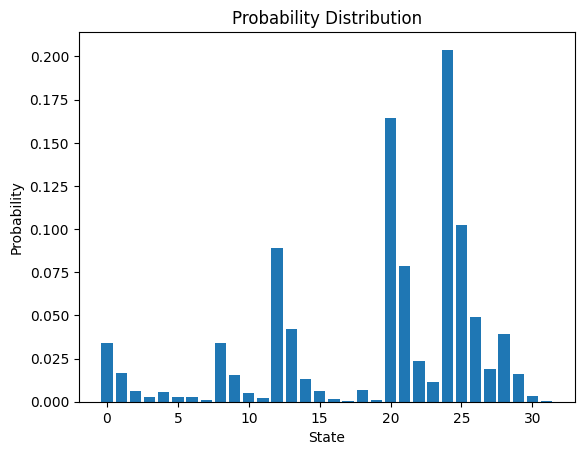

In [32]:
plt.hist(dist, bins=range(2**numberOfWires + 1), align='left')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.title('Measurement Distribution: Simulator Ma')
plt.show()

numberOfWires,initstate,circuitList = ParseCircuit("measure.circuit")
probabilities = [abs(x)**2 for x in DiracToVec(RunCircuitMa(numberOfWires,circuitList))]
plt.bar(range(len(probabilities)),probabilities)
plt.title("Probability Distribution")
plt.xlabel('State')
plt.ylabel('Probability')
plt.show()

In [33]:
def SimulatorMb(InputString):
    numWires,state,circuitList = ParseCircuit(InputString)
    state = np.array(DiracToVec(state)).T
    for element in circuitList:
        if element[0]=='H':
            state = HadamardArray(int(element[1]),numWires) @ state
        elif element[0]=='P':
            state = PhaseArray(int(element[1]),float(element[2]),numWires) @ state
        elif element[0]=='CNOT':
            state = CNOTArray(int(element[1]),int(element[2]),numWires) @ state
    if element[-1]=='MEASURE':
        return Measure(VecToDirac(state.flatten()))
    return VecToDirac(state.flatten())

In [34]:
dist = []
for i in range(1000):
    result = SimulatorMb("measure.circuit")
    dist.append(int(result, 2))

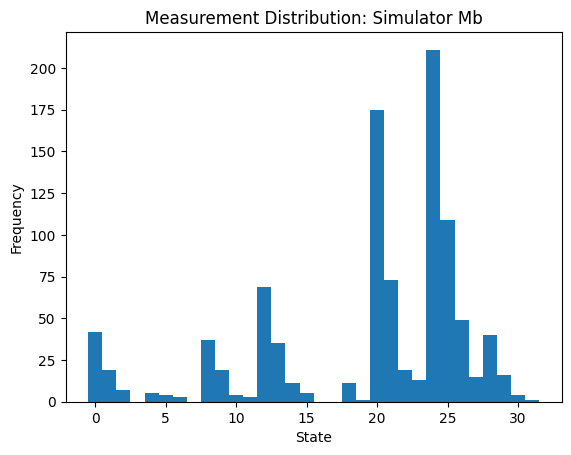

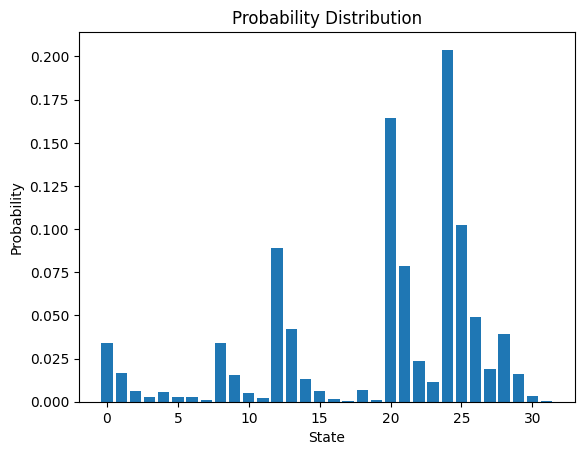

In [35]:
numberOfWires, initstate, circuitList = ParseCircuit("measure.circuit")

plt.hist(dist, bins=range(2**numberOfWires + 1), align='left')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.title('Measurement Distribution: Simulator Mb')
plt.show()

probabilities = [abs(x)**2 for x in DiracToVec(RunCircuitMb(numberOfWires, circuitList))]
plt.bar(range(len(probabilities)), probabilities)
plt.title("Probability Distribution")
plt.xlabel('State')
plt.ylabel('Probability')
plt.show()

### Input

In [36]:
print("SimulatorS Output:")
PrettyPrintBinary(SimulatorS('input.circuit'))
print('#'*100)
print("SimulatorMa Output:")
PrettyPrintBinary(SimulatorMa('input.circuit'))
print('#'*100)
print("SimulatorMb Output:")
PrettyPrintBinary(SimulatorMb('input.circuit'))

SimulatorS Output:
((0.15409919900412572-0.039023142873475775j) |00000> + (-0.02131981307535495+0.08774787414090221j) |00010> + (-0.1480464106395854+0.08745635006745286j) |10000> + (0.11691184507936053+0.013808709741378308j) |10010> + (0.04895105577891031-0.03001851549580141j) |00001> + (-0.1116091892870344-0.23332812293116612j) |00011> + (-0.06328890454391892+0.25662035423302676j) |10001> + (-0.02667646151394929-0.004062838923814427j) |10011> + (-0.033901258348144725-0.009674003342578126j) |00100> + (-0.19592098529914306+0.009885177232733758j) |00110> + (0.21923132553221591-0.21304182634262642j) |10100> + (-0.1479391543721399-0.10481145122901085j) |10110> + (-0.016746063710111725-0.13026586952891356j) |00101> + (-0.09796097290238416+0.013475996833847481j) |00111> + (-0.048941996178234734-0.11635508158684055j) |10101> + (0.2231675743280913+0.05083463296709693j) |10111> + (-0.18082511268453239+0.01438104561772749j) |01000> + (0.0010329113421169653-0.0034553374325645703j) |01010> + (-0.1

# Non-atomic gates
## NOT Gate

In [37]:
PrettyPrintBinary(SimulatorS('''
1
INITSTATE BASIS |1> 
H 0
P 0 3.1415926535897932
H 0
'''))

def compileNOT(wire):
    return [
        ['H', wire],
        ['P', wire, np.pi],
        ['H', wire]
    ]

((0.9999999999999998-6.123233995736765e-17j) |0> + 6.123233995736765e-17j |1>)


## $R_z$ Gate

In [38]:
#Z Gate
PrettyPrintBinary(SimulatorS('''
1
INITSTATE BASIS |1>                             
P 0 3.1415926535897932
'''))

def compileZ(wire):
    return [
        ['P', wire, np.pi]
    ]

((-1+1.2246467991473532e-16j) |1>)


In [ ]:
#Rz Gate
def compileRz(wire, theta):
    return [
        ['P', wire, theta/2],
        *compileNOT(wire),
        ['P', wire, -theta/2],
        *compileNOT(wire)
    ]

PrettyPrintBinary(SimulatorS('''
1
INITSTATE FILE testState.txt                             
P 0 0.3
H 0
P 0 3.1415926535897932
H 0
P 0 -0.3
H 0
P 0 3.1415926535897932
H 0
'''))

[['P', 0, 1.5707963267948966], ['H', 0], ['P', 0, 3.141592653589793], ['H', 0], ['P', 0, -1.5707963267948966], ['H', 0], ['P', 0, 3.141592653589793], ['H', 0]]
((0.6755249097694092-0.20896434210594814j) |0> + (0.6755249097694092+0.20896434210594814j) |1>)


## Swap Gate

In [40]:
def shortSWAP(wire1, wire2):
    return [
        ['CNOT', wire1, wire2],
        ['CNOT', wire2, wire1],
        ['CNOT', wire1, wire2]
    ]
def compileSWAP(wire1, wire2):
    if abs(wire1-wire2)==1:
        return shortSWAP(wire1,wire2)
    else:
        if wire1 > wire2:
            wire1, wire2 = wire2, wire1
        swaps = []
        for i in range(wire1, wire2):
            swaps.extend(shortSWAP(i, i+1))
        for i in range(wire2-1, wire1-1, -1):
            swaps.extend(shortSWAP(i, i+1))
        return swaps

## Long Range CNOT

In [41]:
def compileCNOT(controlWire,notWire):
    if controlWire==notWire: return []
    elif abs(controlWire-notWire)==1: return ['CNOT', controlWire, notWire]
    else:
        if controlWire==0:
            swap = compileSWAP(controlWire+1,notWire)
        else:
            swap = compileSWAP(controlWire-1,notWire)
        return [swap, ['CNOT', controlWire, controlWire+1], swap]


## Control-$R_Z$ Gate

In [ ]:
def compileCRz(controlWire,phaseWire,theta):
    return [
        *compileCNOT(controlWire,phaseWire),
        ['P', phaseWire, theta],
        *compileCNOT(controlWire,phaseWire),
    ]

## Control-Phase Gate

In [ ]:
def compileCPhase(controlWire,phaseWire,theta):
    return [
        ['P', phaseWire, theta/2],
        *compileCNOT(controlWire,phaseWire),
        ['P', phaseWire, -theta/2],
        *compileCNOT(controlWire,phaseWire),
    ]

## Pre-compiling

In [58]:
def compileCircuit(circuitList):
    compiledCircuit = []
    for element in circuitList:
        if element[0]=='H' or element[0]=='P':
            compiledCircuit.append(element)
        elif element[0]=='CNOT':
            compiledCircuit.extend(compileCNOT(int(element[1]),int(element[2])))
        elif element[0]=='NOT':
            compiledCircuit.extend(compileNOT(int(element[1])))
        elif element[0]=='Z':
            compiledCircuit.extend(compileZ(int(element[1])))
        elif element[0]=='Rz':
            compiledCircuit.extend(compileRz(int(element[1]),float(element[2])))
        elif element[0]=='SWAP':
            compiledCircuit.extend(compileSWAP(int(element[1]),int(element[2])))       
    return compiledCircuit

def ParseCircuit(InputString: str):
    if ".circuit" in InputString:
        numWires,circuitList = ReadInputString(open(InputString).read())
    else: 
        numWires,circuitList = ReadInputString(InputString)
    initState = [(1.,'0'*numWires)]
    if circuitList[0][0]=="INITSTATE":
        if circuitList[0][1]=="FILE":
            initState = FileToState(circuitList[0][2])
        elif circuitList[0][1]=="BASIS":
            initState = [(1.,circuitList[0][2][1:-1])]
        circuitList = circuitList[1:]
    return numWires, initState, compileCircuit(circuitList)

In [45]:
def genNonAtomRandCircuit(numWires, numGates):
    circuitList = []
    for i in range(numGates):
        gate = np.random.randint(0, 9)
        match gate:
            case 0: 
                gate = 'H'
                wire = np.random.randint(0, numWires)
                circuitList.append([gate, wire])
            case 1: 
                gate = 'P'
                wire = np.random.randint(0, numWires)
                theta = np.random.random() * 2 * np.pi
                circuitList.append([gate, wire, theta])
            case 2:
                if numWires < 2: continue 
                gate = "CNOT"
                controlWire = np.random.randint(0, numWires)
                notWire = np.random.randint(0, numWires)
                while notWire==controlWire: notWire = np.random.randint(0, numWires)
                circuitList.append([gate, controlWire, notWire])
            case 3:
                gate = 'NOT'
                wire = np.random.randint(0, numWires)
                circuitList.append([gate, wire])
            case 4:
                gate = 'Rz'
                wire = np.random.randint(0, numWires)
                theta = np.random.random() * 2 * np.pi
                circuitList.append([gate, wire, theta])
            case 5:
                gate = 'Z'
                wire = np.random.randint(0, numWires)
                circuitList.append([gate,wire])
            case 6:
                if numWires < 2: continue
                gate = 'CRz'
                controlWire = np.random.randint(0, numWires)
                phaseWire = np.random.randint(0, numWires)
                while phaseWire==controlWire : phaseWire = np.random.randint(0, numWires)
                circuitList.append([gate, controlWire, phaseWire])
            case 7:
                if numWires < 2: continue
                gate = 'CPhase'
                controlWire = np.random.randint(0, numWires)
                phaseWire = np.random.randint(0, numWires)
                while phaseWire==controlWire : phaseWire = np.random.randint(0, numWires)
                theta = np.random.random() * 2 * np.pi
                circuitList.append([gate, controlWire, phaseWire, theta])
            case 8:
                if numWires < 2: continue
                gate = 'SWAP'
                wire1 = np.random.randint(0, numWires)
                wire2 = np.random.randint(0, numWires)
                while wire1 == wire2:
                    wire2 = np.random.randint(0, numWires)
                circuitList.append([gate, wire1, wire2])
    return circuitList

In [46]:
X = genNonAtomRandCircuit(4,10)
print(X)
print('#'*100)
print(compileCircuit(X))

[['NOT', 0], ['H', 3], ['Z', 0], ['CPhase', 0, 1, 1.1424809724304332], ['SWAP', 2, 1], ['H', 2], ['P', 1, 0.7859393701854739], ['Rz', 3, 4.517638356677706], ['NOT', 0], ['CPhase', 1, 0, 1.4507685604740355]]
####################################################################################################
[['H', 0], ['P', 0, 3.141592653589793], ['H', 0], ['H', 3], ['P', 0, 3.141592653589793], ['CNOT', 2, 1], ['CNOT', 1, 2], ['CNOT', 2, 1], ['H', 2], ['P', 1, 0.7859393701854739], ['P', 3, 2.258819178338853], ['H', 3], ['P', 3, 3.141592653589793], ['H', 3], ['P', 3, -2.258819178338853], ['H', 3], ['P', 3, 3.141592653589793], ['H', 3], ['H', 0], ['P', 0, 3.141592653589793], ['H', 0]]


In [62]:
# Test for NOT Gate
print("NOT Gate Test:")
print("SimulatorS Output:")
PrettyPrintBinary(SimulatorS('''
1
INITSTATE BASIS |1> 
NOT 0
'''))
print('#'*100)
print("SimulatorMa Output:")
PrettyPrintBinary(SimulatorMa('''
1
INITSTATE BASIS |1> 
NOT 0
'''))
print('#'*100)
print("SimulatorMb Output:")
PrettyPrintBinary(SimulatorMb('''
1
INITSTATE BASIS |1> 
NOT 0
'''))
print('#'*100)

# Test for Z Gate
print("Z Gate Test:")
print("SimulatorS Output:")
PrettyPrintBinary(SimulatorS('''
1
INITSTATE BASIS |1> 
Z 0
'''))
print('#'*100)
print("SimulatorMa Output:")
PrettyPrintBinary(SimulatorMa('''
1
INITSTATE BASIS |1> 
Z 0
'''))
print('#'*100)
print("SimulatorMb Output:")
PrettyPrintBinary(SimulatorMb('''
1
INITSTATE BASIS |1> 
Z 0
'''))
print('#'*100)

# Test for Rz Gate
print("Rz Gate Test:")
print("SimulatorS Output:")
PrettyPrintBinary(SimulatorS('''
1
INITSTATE BASIS |1> 
Rz 0 1.57079632679
'''))
print('#'*100)
print("SimulatorMa Output:")
PrettyPrintBinary(SimulatorMa('''
1
INITSTATE BASIS |1> 
Rz 0 1.57079632679
'''))
print('#'*100)
print("SimulatorMb Output:")
PrettyPrintBinary(SimulatorMb('''
1
INITSTATE BASIS |1> 
Rz 0 1.57079632679
'''))
print('#'*100)

# Test for SWAP Gate
print("SWAP Gate Test:")
print("SimulatorS Output:")
PrettyPrintBinary(SimulatorS('''
2
INITSTATE BASIS |10> 
SWAP 0 1
'''))
print('#'*100)
print("SimulatorMa Output:")
PrettyPrintBinary(SimulatorMa('''
2
INITSTATE BASIS |10> 
SWAP 0 1
'''))
print('#'*100)
print("SimulatorMb Output:")
PrettyPrintBinary(SimulatorMb('''
2
INITSTATE BASIS |10> 
SWAP 0 1
'''))
print('#'*100)

# Test for CNOT Gate
print("CNOT Gate Test:")
print("SimulatorS Output:")
PrettyPrintBinary(SimulatorS('''
2
INITSTATE BASIS |10> 
CNOT 0 1
'''))
print('#'*100)
print("SimulatorMa Output:")
PrettyPrintBinary(SimulatorMa('''
2
INITSTATE BASIS |10> 
CNOT 0 1
'''))
print('#'*100)
print("SimulatorMb Output:")
PrettyPrintBinary(SimulatorMb('''
2
INITSTATE BASIS |10> 
CNOT 0 1
'''))
print('#'*100)

# Test for CRz Gate
print("CRz Gate Test:")
print("SimulatorS Output:")
PrettyPrintBinary(SimulatorS('''
2
INITSTATE BASIS |10> 
CRz 0 1 1.57079632679
'''))
print('#'*100)
print("SimulatorMa Output:")
PrettyPrintBinary(SimulatorMa('''
2
INITSTATE BASIS |10> 
CRz 0 1 1.57079632679
'''))
print('#'*100)
print("SimulatorMb Output:")
PrettyPrintBinary(SimulatorMb('''
2
INITSTATE BASIS |10> 
CRz 0 1 1.57079632679
'''))
print('#'*100)

# Test for CPhase Gate
print("CPhase Gate Test:")
print("SimulatorS Output:")
PrettyPrintBinary(SimulatorS('''
2
INITSTATE BASIS |10> 
CPhase 0 1 1.57079632679
'''))
print('#'*100)
print("SimulatorMa Output:")
PrettyPrintBinary(SimulatorMa('''
2
INITSTATE BASIS |10> 
CPhase 0 1 1.57079632679
'''))
print('#'*100)
print("SimulatorMb Output:")
PrettyPrintBinary(SimulatorMb('''
2
INITSTATE BASIS |10> 
CPhase 0 1 1.57079632679
'''))
print('#'*100)

NOT Gate Test:
SimulatorS Output:
((0.9999999999999998-6.123233995736765e-17j) |0> + 6.123233995736765e-17j |1>)
####################################################################################################
SimulatorMa Output:
((0.9999999999999998-6.123233995736765e-17j) |0> + 6.123233995736765e-17j |1>)
####################################################################################################
SimulatorMb Output:
((0.9999999999999998-6.123233995736765e-17j) |0> + 6.123233995736765e-17j |1>)
####################################################################################################
Z Gate Test:
SimulatorS Output:
((-1+1.2246467991473532e-16j) |1>)
####################################################################################################
SimulatorMa Output:
((-1+1.2246467991473532e-16j) |1>)
####################################################################################################
SimulatorMb Output:
((-1+1.2246467991473532e-16j) |1>)
#######

TypeError: 'int' object is not subscriptable